# Ozone forcing


Skeie et al. 2021:

- time series of all depleters, warming included

Individual contributions to present day ozone forcing (estimated from figure 7, Thornhill et al 2021) with no climate contribution:

- N2O +0.04
- VOC +0.11
- NOx +0.14
- CH4 +0.17  (O'Connor et al. says +0.13 or +0.20 depending on method; we use +0.13)
- HC  -0.33
- climate -0.079 W/m2/K  (table 14 other Thornhill paper)
- sum +0.13  (without climate feedack)  (+0.09 with pre-calibrated methane from O'Connor which does not include climate feedback either)
- sum +0.05  (with climate feedback assuming +1.0K 1850-2014; +0.01 if assume O'Connor)

This falls a little short, possibly the use of the ozone radiative kernel means that estimates are not perfect in either Skeie or Thornhill x 2, or that there is some additional non-linearity that kicks into the estimates.

**Possible effect of ACI from ozone: drove a stronger negative forcing than expected - can we fit the residual?**

**look at histSST-piO3 and fit the time series to emissions of NOx, VOC and CO**

In [1]:
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

/Users/c.l.b.alexander/Documents/FAIR/fair_virtual_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
st_df = pd.read_csv('../data/skeie2020/skeie_ozone_strat.csv', index_col="Model")
tr_df = pd.read_csv('../data/skeie2020/skeie_ozone_trop.csv', index_col="Model")

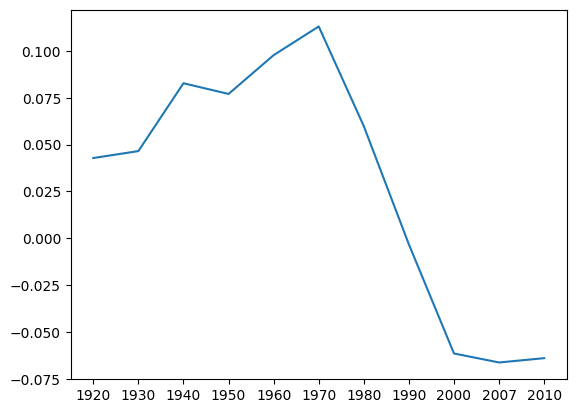

In [3]:
# Skeie uses 10 year averages: 1920 is 1916-1925 up to 2000. 2007 is 2003-2012. 2010 is 2005-2014.
o3_ukesm = st_df.loc['UKESM1-0-LL'] + tr_df.loc['UKESM1-0-LL']
pl.plot(o3_ukesm)

In [4]:
temp_ukesm = np.ones((165, 19)) * np.nan
for run in range(19):
    try:
        temp_ukesm[:, run] = pd.read_csv('../data/fredriksen2022/historical/UKESM1-0-LL_historical_r%di1p1f2_anomalies.txt' %(run+1), index_col=0)['tas'].values
    except FileNotFoundError:
        pass

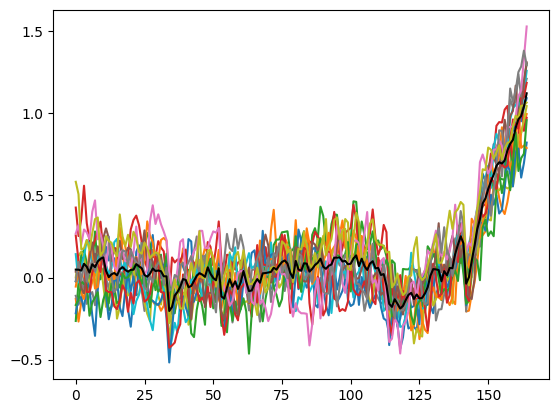

In [5]:
pl.plot(temp_ukesm);
temp_ukesm_mean = np.nanmean(temp_ukesm, axis=1)
pl.plot(temp_ukesm_mean, color='k')

In [6]:
climate_response_df = pd.read_csv('../data/fair-calibrations/4xCO2_energy_balance_ebm3.csv')

In [7]:
natural_forcing_df = pd.read_csv('../data/calibration/natural_forcing.csv', index_col=0)

In [8]:
f = FAIR(temperature_prescribed=True)

In [9]:
scenarios = ['ssp245']
configs = ['UKESM1-0-LL']
species, properties = read_properties(filename='../data/species_configs_properties_vanilla.csv')
species.remove('CO2 FFI')      # c-driven run
species.remove('CO2 AFOLU')    # c-driven run
species.remove('Halon-1202')   # not in CMIP6 list of species
species.remove('Contrails')    # not modelled in UKESM, I think
species.remove('NOx aviation') # which renders this redundant
species.remove('Light absorbing particles on snow and ice')  # I believe not modelled in UKESM
del properties['CO2 FFI']
del properties['CO2 AFOLU']
del properties['Halon-1202']
del properties['Contrails']
del properties['NOx aviation']
del properties['Light absorbing particles on snow and ice']
for specie in species:
    if properties[specie]['greenhouse_gas']:
        properties[specie]['input_mode'] = 'concentration'
properties['Land use']['input_mode'] = 'forcing'

In [10]:
f.define_time(1850, 2015, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
f.define_species(species, properties)

In [11]:
f.allocate()

In [12]:
fill(f.climate_configs['ocean_heat_capacity'], climate_response_df.loc[0, 'C1':'C3'])
fill(f.climate_configs['ocean_heat_transfer'], climate_response_df.loc[0, 'kappa1':'kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], climate_response_df.loc[0, 'epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], climate_response_df.loc[0, 'gamma'])

In [13]:
initialise(f.forcing, 0)
initialise(f.temperature, 0)

In [14]:
f.fill_species_configs(filename='../data/species_configs_properties_vanilla.csv')

In [15]:
f.fill_from_rcmip()

In [16]:
# override RCMIP natural forcing
fill(f.forcing, np.array(natural_forcing_df.loc[1850:2015, 'solar'])[:, None, None], specie='Solar')
fill(f.forcing, np.array(natural_forcing_df.loc[1850:2015, 'volcanic'])[:, None, None], specie='Volcanic')

In [17]:
f.emissions[:,0,0,3:10]

<xarray.DataArray (timepoints: 165, specie: 7)> Size: 9kB
array([[  4.54446378,   2.57112448,  18.22682479, ...,  13.45657685,
         66.78304875, 411.46287432],
       [  4.50659972,   2.52669259,  17.72630049, ...,  13.17243992,
         64.95004659, 402.24481525],
       [  4.54817338,   2.50763416,  17.47926155, ...,  13.00181932,
         63.95789986, 397.49851999],
       ...,
       [115.66957641,   9.70528517,  35.82690196, ..., 158.23998797,
        229.10693624, 949.60221835],
       [114.64817742,   9.56055374,  33.24556583, ..., 156.03755649,
        219.38117925, 901.23875664],
       [114.0086622 ,   9.74437966,  36.14582139, ..., 155.64022547,
        233.52551801, 964.04761815]], shape=(165, 7))
Coordinates:
  * timepoints  (timepoints) float64 1kB 1.85e+03 1.852e+03 ... 2.014e+03
    scenario    <U6 24B 'ssp245'
    config      <U11 44B 'UKESM1-0-LL'
  * specie      (specie) <U43 1kB 'Sulfur' 'BC' 'OC' 'NH3' 'NOx' 'VOC' 'CO'

In [18]:
f.emissions.loc[dict(specie='Sulfur', timepoints=1850.5)]

<xarray.DataArray (scenario: 1, config: 1)> Size: 8B
array([[4.54446378]])
Coordinates:
    timepoints  float64 8B 1.85e+03
  * scenario    (scenario) <U6 24B 'ssp245'
  * config      (config) <U11 44B 'UKESM1-0-LL'
    specie      <U43 172B 'Sulfur'

In [19]:
landuse_erf = pd.read_csv('../data/calibration/landuse_forcing.csv', index_col=0)
f.forcing.loc[dict(specie='Land use', scenario='ssp245', config='UKESM1-0-LL')] = landuse_erf.values[:166, 1]

In [20]:
# 1850 baselines
for specie in ['Sulfur', 'BC', 'OC', 'NOx', 'VOC', 'CO', 'NH3']:
    f.species_configs['baseline_emissions'].loc[dict(specie=specie)] = f.emissions.loc[dict(specie=specie, timepoints=1850.5, scenario='ssp245')]

for specie in ['CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
    'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
    'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
    'HFC-32', 'HFC-365mfc', 'HFC-4310mee']:
    f.species_configs['baseline_concentration'].loc[dict(specie=specie)] = f.concentration.loc[dict(specie=specie, timebounds=1850, scenario='ssp245')]

# check this against the last cell in this script
f.species_configs['baseline_concentration'].loc[dict(specie='Equivalent effective stratospheric chlorine')] = 344.36275911

## rebase volcanic to zero mean
#f.forcing.loc[dict(specie='Volcanic')] = f.forcing.loc[dict(specie='Volcanic')] - f.forcing.loc[dict(specie='Volcanic', scenario='ssp245', config='UKESM1-0-LL')].mean()

In [21]:
# fill temperature
f.temperature[:-1, ...] = temp_ukesm_mean[:, None, None, None]
f.temperature[-1, ...] = f.temperature[-2, ...]

# pre-calibrated for aerosol (05) and CH4 (07) runs: do not adjust
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='Sulfur')] = -0.00283793
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='BC')] = 0.01757433
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='OC')] = -0.0028512
f.species_configs['aci_scale'].loc[dict(config='UKESM1-0-LL')] = -8.22336281e-01
f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 3.01888722e-02
f.species_configs['aci_shape'].loc[dict(specie='BC')] = 5.07111186e-30
f.species_configs['aci_shape'].loc[dict(specie='OC')] = 6.60381587e-16
f.species_configs['forcing_scale'].loc[dict(specie="CH4")] = 1.11547955
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="CH4")] = 1.27049657e-04
f.species_configs['h2o_stratospheric_factor'].loc[dict(specie="CH4")] = 1.29652705e-01
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie="CH4")] = -5.09377882e-05
f.species_configs['aci_shape'].loc[dict(specie="CH4")] = -2.61186113e-04

# co-calibrated with N2O (10) and CO2 (09) runs:
f.species_configs['forcing_scale'].loc[dict(specie="N2O")] = 1.16044956348451
f.species_configs['forcing_scale'].loc[dict(specie="CO2")] = 1.04321901751203

In [22]:
ch4 = f.concentration.loc[dict(specie='CH4')].squeeze().values
n2o = f.concentration.loc[dict(specie='N2O')].squeeze().values
eesc = f.concentration.loc[dict(specie='Equivalent effective stratospheric chlorine')].squeeze().values

voc = f.emissions.loc[dict(specie='VOC')].squeeze().values
co = f.emissions.loc[dict(specie='CO')].squeeze().values
nox = f.emissions.loc[dict(specie='NOx')].squeeze().values
print(eesc[-2])

nan


In [23]:
# values from Thornhill
n2o_eff = 0.04 / (n2o[164]-n2o[0])
voc_eff = 0.11 / (voc[164]-voc[0])
nox_eff = 0.14 / (nox[164]-nox[0])
eesc_eff = -0.33 / (1.13324964e+03)# precalc - also the forcing in the present day has been hand tuned to fit skeie much better
n2o_eff, voc_eff, nox_eff, eesc_eff

(np.float64(0.0007481397748679878),
 np.float64(0.0006596999582126578),
 np.float64(0.000984642055228785),
 -0.00029119797470220245)

In [24]:
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="Equivalent effective stratospheric chlorine")] = eesc_eff
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="N2O")] = n2o_eff
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="VOC")] = voc_eff
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="NOx")] = nox_eff
f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Ozone")] = -0.079  # Thornhill et al 2021 feedbacks

In [25]:
f.run()

Running 1 projections in parallel: 100%|██████████| 165/165 [00:00<00:00, 5320.67timesteps/s]


In [26]:
# print('N2O               %+7.5f' % f.forcing.values[-2:-1,0,0,1].mean())
print('Ozone             %+7.5f' % f.forcing.values[-2:-1,0,0,54].mean())
# print('ARI               %+7.5f' % f.forcing.values[-2:-1,0,0,10].mean())
# print('ACI               %+7.5f' % f.forcing.values[-2:-1,0,0,11].mean())
# print('Sum of components %+7.5f' % (f.forcing.values[-2:-1,0,0,1]+f.forcing.values[-2:-1,0,0,9]+f.forcing.values[-2:-1,0,0,10]+f.forcing.values[-2:-1,0,0,11]))
print('Scenario sum      %+7.5f' % f.forcing_sum.values[-2:-1,0,0].mean())

Ozone             -0.00181
Scenario sum      +1.69069


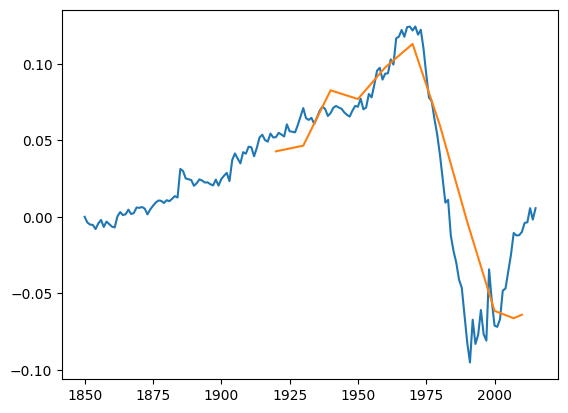

In [27]:
pl.plot(f.timebounds, f.forcing.loc[dict(specie='Ozone', scenario='ssp245', config='UKESM1-0-LL')])
pl.plot(o3_ukesm.index.map(float), o3_ukesm)

In [28]:
f.forcing[1, 0, 0, :]

<xarray.DataArray (specie: 58)> Size: 464B
array([ 2.33846950e-03,  7.86174522e-05,  2.78407004e-04,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.34574633e-09,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.20702622e-11,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.25596748e-11,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.82991362e-10,
        0.00000000e+00,  0.00000000e+00, -1.27296891e-02,  2.57553407e-01,
       -5.65663175e-06,  2.30891061e-05, -3.72793661e-03,  1.01929653e-05,
       -5.57008574e-04,             nan])
Coordinates:
    timebounds  float64 8B 1.851e+03
    scenario    <U6 24B 'ssp245'
    config      <U11 44B 'UKESM1-0-LL'
  * specie      (specie) <U43 10kB 'CO2' ... 'Equivalent effective stratosphe...

In [29]:
f.forcing_sum[1, 0, 0]

<xarray.DataArray ()> Size: 8B
array(0.24326189)
Coordinates:
    timebounds  float64 8B 1.851e+03
    scenario    <U6 24B 'ssp245'
    config      <U11 44B 'UKESM1-0-LL'

In [30]:
f.temperature[:, 0, 0, 0]

<xarray.DataArray (timebounds: 166)> Size: 1kB
array([ 0.04801211,  0.04773469,  0.04232715,  0.08409721,  0.06541477,
        0.02983611,  0.0809258 ,  0.06329391,  0.09837819,  0.11419015,
        0.12253011,  0.04109118,  0.00194987,  0.01942573,  0.02757699,
        0.01358043,  0.04992295,  0.06344228,  0.04660372,  0.03571377,
        0.04662869,  0.04787677,  0.08174344,  0.06794762,  0.05625099,
        0.01531729,  0.00510756,  0.02294473,  0.05500792,  0.03950472,
        0.04281296,  0.0381972 ,  0.00756959,  0.00717404, -0.2040876 ,
       -0.17930949, -0.11075091, -0.08792814, -0.0568019 , -0.00959829,
       -0.01468931, -0.05908695, -0.05134285, -0.02070532,  0.0113971 ,
        0.02637201,  0.01778171,  0.0040183 ,  0.06173665,  0.02280691,
       -0.00284844, -0.01680584,  0.05641834, -0.11599321, -0.12872764,
       -0.06093759, -0.00965891, -0.05650998, -0.02323653, -0.0698477 ,
       -0.02906246,  0.03999547, -0.02764712, -0.08234961, -0.07883084,
       -0.03783752, -0.00965571, -0.03181427,  0.02564869,  0.02712989,
        0.03062934,  0.03411264,  0.05986687,  0.04766052,  0.07364113,
        0.09431524,  0.10416941,  0.08549873,  0.0290874 , -0.00261566,
        0.10127599,  0.04904706,  0.04067236,  0.08662368,  0.08491126,
        0.03575294,  0.05288574,  0.07602025,  0.08997738,  0.11499208,
        0.06579091,  0.05319782,  0.07144312,  0.07958868,  0.12080043,
        0.12131613,  0.12257817,  0.09760163,  0.10148555,  0.08101615,
        0.08398104,  0.11655905,  0.13465235,  0.06941919,  0.11459925,
        0.07020619,  0.04575649,  0.08490238,  0.09917697,  0.05597492,
        0.05812814,  0.0155823 ,  0.02099472, -0.04991045, -0.1605067 ,
       -0.17914581, -0.13264436, -0.15969731, -0.18867273, -0.1731419 ,
       -0.13763143, -0.10594505, -0.09367173, -0.13047114, -0.1033115 ,
       -0.12765362, -0.12380207, -0.09702705, -0.05945197,  0.01143906,
        0.051286  ,  0.04961122,  0.04533658, -0.02289033,  0.03887869,
        0.01343583,  0.05868864,  0.05660779,  0.14394317,  0.20032922,
        0.25117466,  0.20831723, -0.03729627,  0.00180835,  0.10054084,
        0.18965146,  0.29253256,  0.35674245,  0.45127706,  0.48224668,
        0.53913967,  0.58520389,  0.62722759,  0.68060229,  0.70253831,
        0.69487557,  0.71331876,  0.77497722,  0.81505441,  0.83890311,
        0.91309976,  0.96504978,  0.98423083,  1.04186175,  1.1228577 ,
        1.1228577 ])
Coordinates:
  * timebounds  (timebounds) float64 1kB 1.85e+03 1.851e+03 ... 2.015e+03
    scenario    <U6 24B 'ssp245'
    config      <U11 44B 'UKESM1-0-LL'
    layer       int64 8B 0

In [31]:
f.concentration.sel(specie='Equivalent effective stratospheric chlorine', timebounds=np.arange(1850, 1853))

<xarray.DataArray (timebounds: 3, scenario: 1, config: 1)> Size: 24B
array([[[         nan]],

       [[344.36275911]],

       [[344.36275911]]])
Coordinates:
  * timebounds  (timebounds) float64 24B 1.85e+03 1.851e+03 1.852e+03
  * scenario    (scenario) <U6 24B 'ssp245'
  * config      (config) <U11 44B 'UKESM1-0-LL'
    specie      <U43 172B 'Equivalent effective stratospheric chlorine'

In [32]:
f.concentration.sel(specie='Equivalent effective stratospheric chlorine', timebounds=np.arange(2014, 2016))

<xarray.DataArray (timebounds: 2, scenario: 1, config: 1)> Size: 16B
array([[[1477.61239857]],

       [[1467.83772966]]])
Coordinates:
  * timebounds  (timebounds) float64 16B 2.014e+03 2.015e+03
  * scenario    (scenario) <U6 24B 'ssp245'
  * config      (config) <U11 44B 'UKESM1-0-LL'
    specie      <U43 172B 'Equivalent effective stratospheric chlorine'